Data Selection

In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.io as pio
%matplotlib inline
pio.renderers.default = "notebook"

In [62]:
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 2018
NO_EPOCHS = 50
BATCH_SIZE = 128

IS_LOCAL = False

import os
if(IS_LOCAL):
    PATH="/kaggle/input/fashionmnist/"
else:
    PATH="/kaggle/input/fashionmnist/"
print(os.listdir(PATH))

['t10k-labels-idx1-ubyte', 't10k-images-idx3-ubyte', 'fashion-mnist_test.csv', 'fashion-mnist_train.csv', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte']


In [63]:
train_file = PATH+"fashion-mnist_train.csv"
test_file  = PATH+"fashion-mnist_test.csv"

train_data = pd.read_csv(train_file)
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
train_data.shape

(60000, 785)

In [65]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [66]:
test_data = pd.read_csv(test_file)
test_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
test_data.shape

(10000, 785)

In [68]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

In [69]:
def get_classes_distribution(data):
    label_counts = data["label"].value_counts()
    total_samples = len(data)
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(train_data)

Pullover            :   6000 or 10.0%
Ankle Boot          :   6000 or 10.0%
Shirt               :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%
Dress               :   6000 or 10.0%
Coat                :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Bag                 :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Trouser             :   6000 or 10.0%


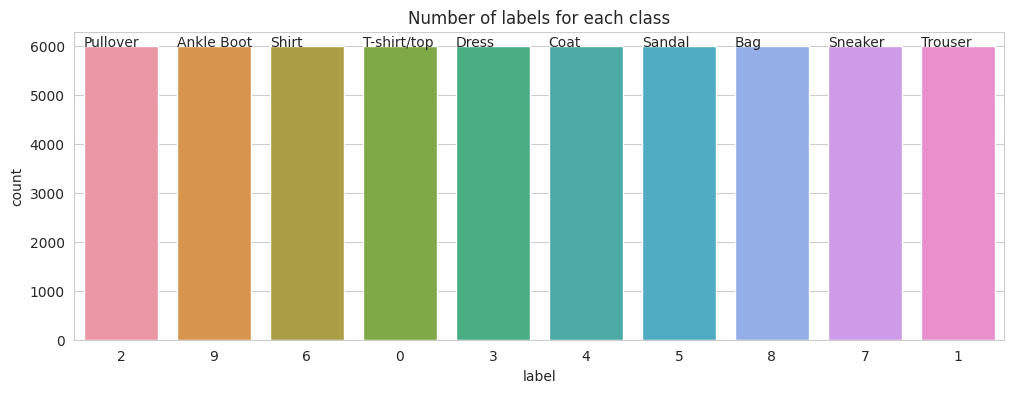

In [70]:
def plot_label_per_class(data):
    figure, axes = plt.subplots(1,1, figsize=(12,4))
    class_count_plot = sns.countplot(x=data.label, order = data["label"].value_counts().index,ax=axes)
    class_count_plot.set_title("Number of labels for each class")

    for bar, label in zip(class_count_plot.patches, data["label"].value_counts().index):
        class_count_plot.annotate(labels[label], (bar.get_x(), bar.get_height()+0.1))
    plt.show()  
    
plot_label_per_class(train_data)

In [71]:
get_classes_distribution(test_data)

T-shirt/top         :   1000 or 10.0%
Trouser             :   1000 or 10.0%
Pullover            :   1000 or 10.0%
Dress               :   1000 or 10.0%
Bag                 :   1000 or 10.0%
Shirt               :   1000 or 10.0%
Sandal              :   1000 or 10.0%
Coat                :   1000 or 10.0%
Sneaker             :   1000 or 10.0%
Ankle Boot          :   1000 or 10.0%


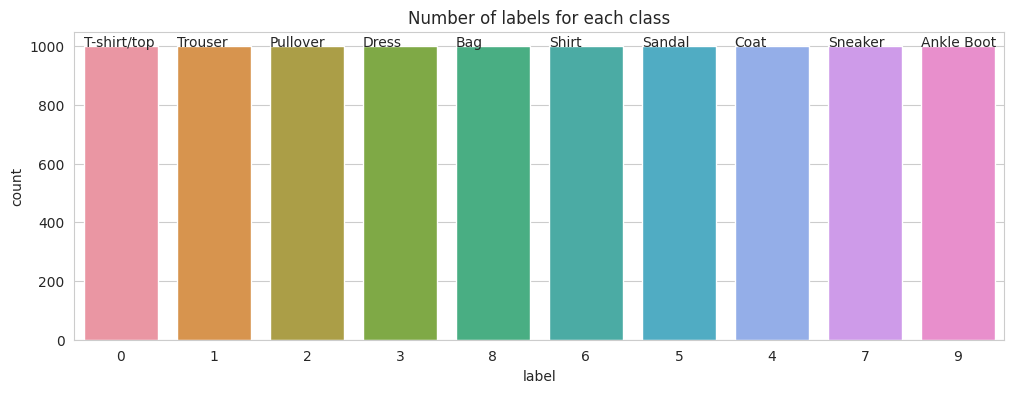

In [72]:
plot_label_per_class(test_data)

In [73]:
def sample_images_data(data):
    sample_images = []
    sample_labels = []
    for k in labels.keys():
        samples = data[data["label"] == k].head(4)
        for j, s in enumerate(samples.values):
            img = np.array(samples.iloc[j, 1:]).reshape(IMG_ROWS,IMG_COLS)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 0])
    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels
train_sample_images, train_sample_labels = sample_images_data(train_data)

Total number of sample images to plot:  40


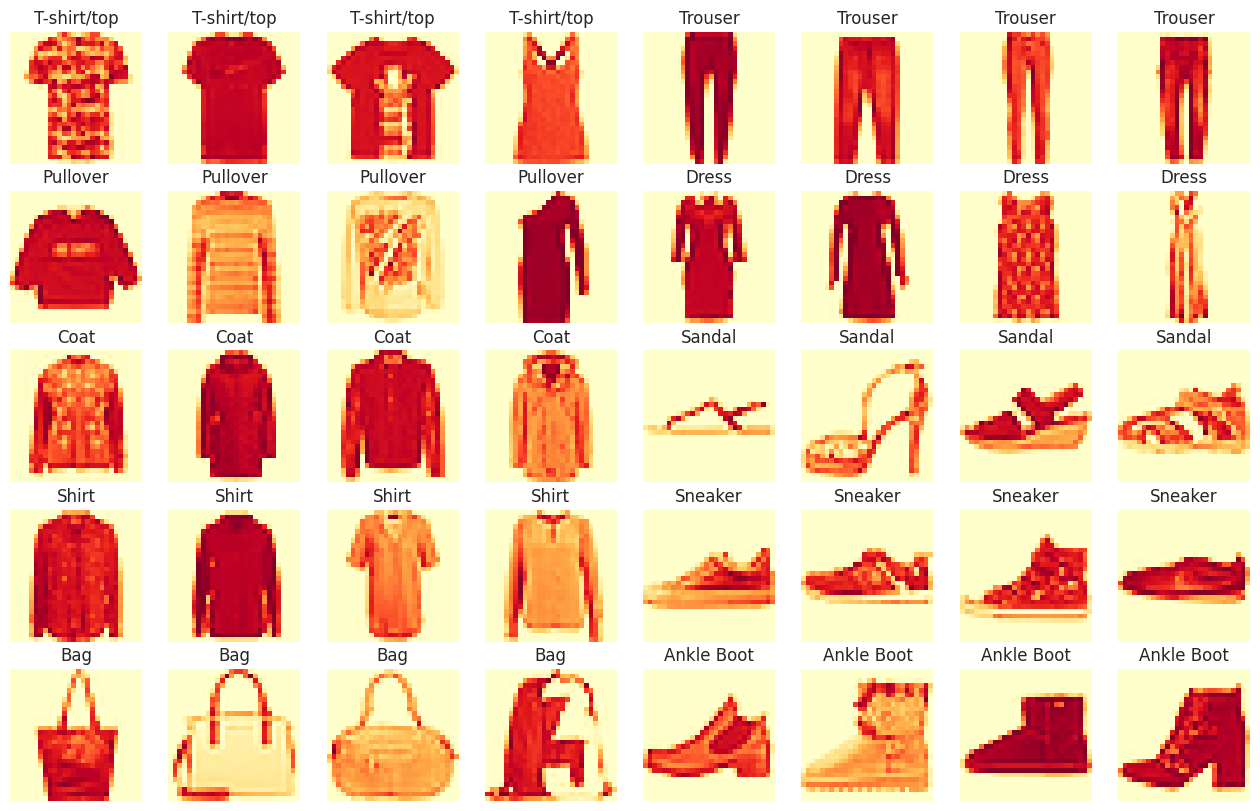

In [74]:
def plot_sample_images(data_sample_images,data_sample_labels,cmap="Blues"):
    f, ax = plt.subplots(5,8, figsize=(16,10))
    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[data_sample_labels[i]])
    plt.show()    
plot_sample_images(train_sample_images,train_sample_labels, "YlOrRd")

In [75]:
test_sample_images, test_sample_labels = sample_images_data(test_data)

Total number of sample images to plot:  40


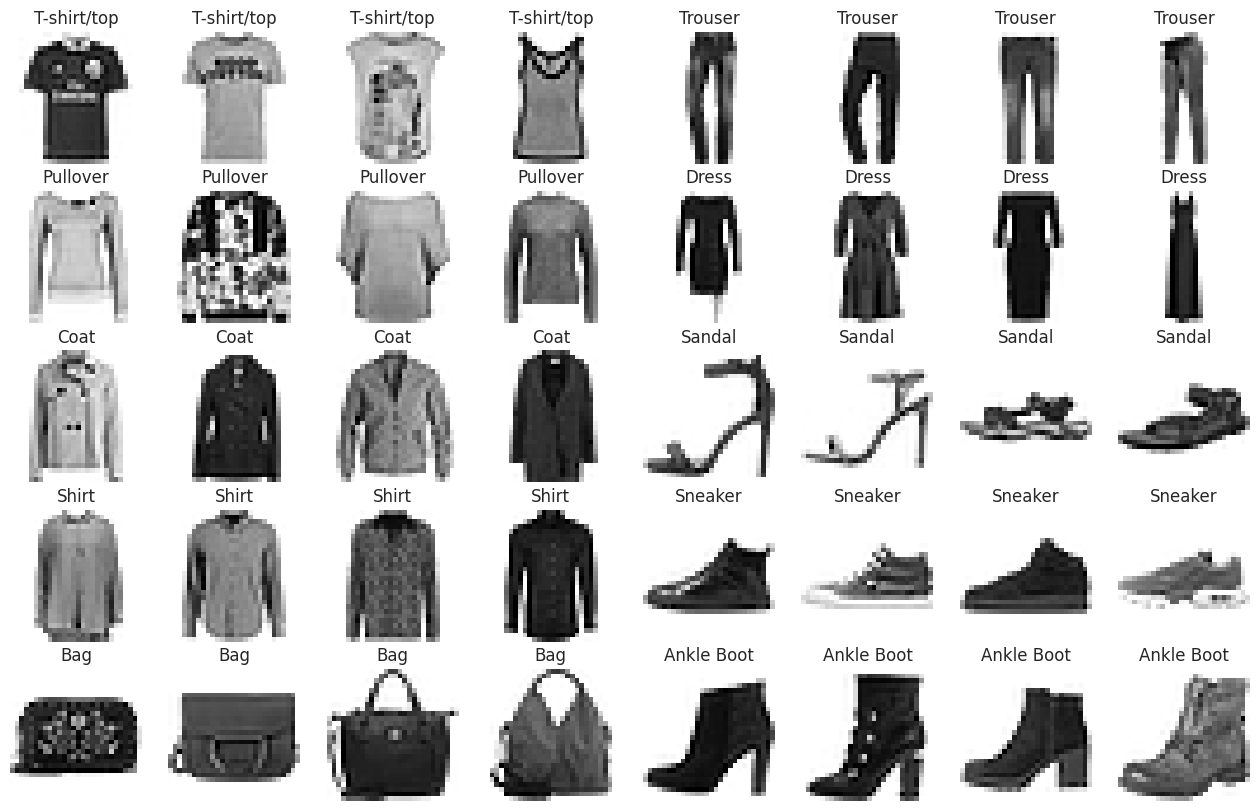

In [76]:
plot_sample_images(test_sample_images,test_sample_labels,"binary")

****Model****

In [77]:
def data_preprocessing(raw):
    out_y = keras.utils.to_categorical(raw.label, NUM_CLASSES)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

In [78]:
X, y = data_preprocessing(train_data)
X_test, y_test = data_preprocessing(test_data)

In [79]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [80]:
print("Fashion MNIST train -  rows:",X_train.shape[0]," columns:", X_train.shape[1:4])
print("Fashion MNIST valid -  rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("Fashion MNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

Fashion MNIST train -  rows: 48000  columns: (28, 28, 1)
Fashion MNIST valid -  rows: 12000  columns: (28, 28, 1)
Fashion MNIST test -  rows: 10000  columns: (28, 28, 1)


In [81]:
def plot_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(x=ydf[0], order = np.arange(0,10))
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")
    
    for p, label in zip(g.patches, np.arange(0,10)):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))
        
    plt.show()

In [82]:
def get_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    label_counts = ydf[0].value_counts()
    total_samples = len(yd)
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

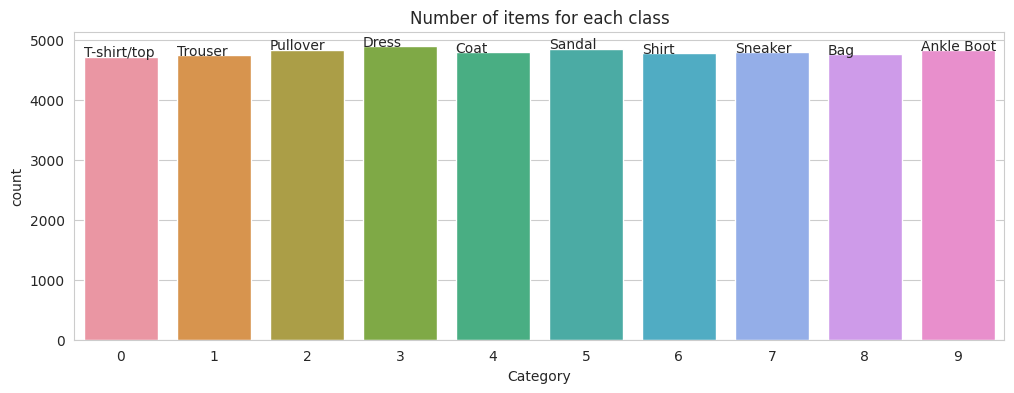

Dress               :   4891 or 10.189583333333333%
Sandal              :   4855 or 10.114583333333334%
Pullover            :   4836 or 10.075000000000001%
Ankle Boot          :   4827 or 10.05625%
Sneaker             :   4798 or 9.995833333333334%
Coat                :   4796 or 9.991666666666667%
Shirt               :   4779 or 9.95625%
Bag                 :   4757 or 9.910416666666666%
Trouser             :   4745 or 9.885416666666668%
T-shirt/top         :   4716 or 9.825000000000001%


In [83]:
plot_count_per_class(np.argmax(y_train,axis=1))
get_count_per_class(np.argmax(y_train,axis=1))

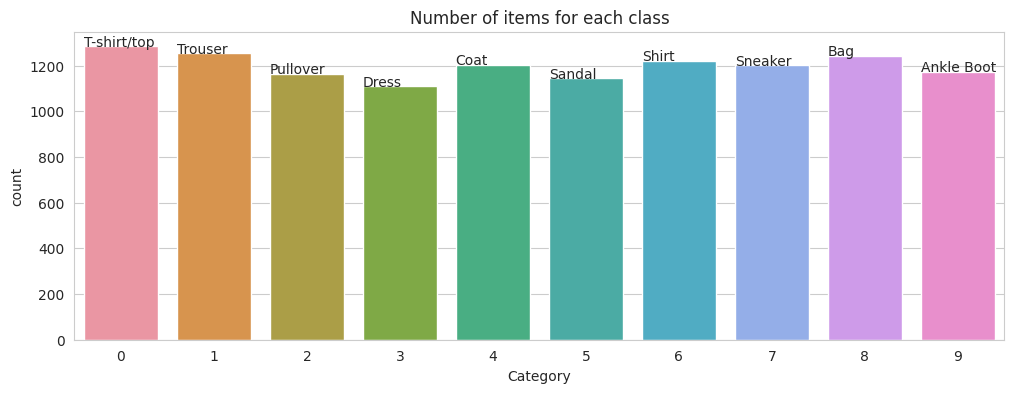

T-shirt/top         :   1284 or 10.7%
Trouser             :   1255 or 10.458333333333334%
Bag                 :   1243 or 10.358333333333333%
Shirt               :   1221 or 10.174999999999999%
Coat                :   1204 or 10.033333333333333%
Sneaker             :   1202 or 10.016666666666667%
Ankle Boot          :   1173 or 9.775%
Pullover            :   1164 or 9.700000000000001%
Sandal              :   1145 or 9.541666666666666%
Dress               :   1109 or 9.241666666666665%


In [84]:
plot_count_per_class(np.argmax(y_val,axis=1))
get_count_per_class(np.argmax(y_val,axis=1))

In [86]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

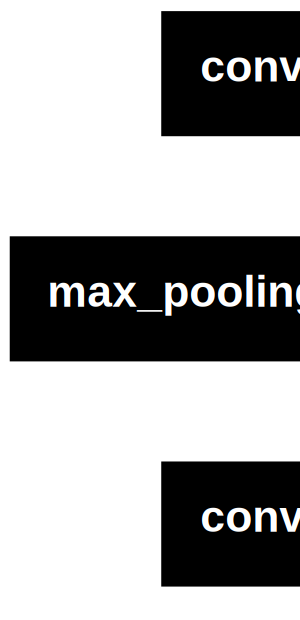

In [ ]:
plot_model(model, to_file='outputs/model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [89]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7266 - loss: 0.7696 - val_accuracy: 0.8521 - val_loss: 0.4021
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8678 - loss: 0.3620 - val_accuracy: 0.8773 - val_loss: 0.3415
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8893 - loss: 0.3041 - val_accuracy: 0.8895 - val_loss: 0.3105
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8987 - loss: 0.2731 - val_accuracy: 0.8987 - val_loss: 0.2813
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9106 - loss: 0.2401 - val_accuracy: 0.9026 - val_loss: 0.2780
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9203 - loss: 0.2165 - val_accuracy: 0.8986 - val_loss: 0.2859
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9244 - loss: 0.2028 - val_accuracy: 0.9084 - val_loss: 0.2648
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9351 - loss: 0.1735 - val_accuracy: 0.

In [90]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7504110336303711
Test accuracy: 0.9078999757766724


In [93]:
import matplotlib.pyplot as plt
def create_trace(x, y, ylabel, color):
    return {'x': x, 'y': y, 'label': ylabel, 'color': color}

def plot_accuracy_and_loss(train_model,image_name):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1, len(acc)+1))
    
    trace_ta = create_trace(epochs, acc, "Training accuracy", "Green")
    trace_va = create_trace(epochs, val_acc, "Validation accuracy", "Red")
    trace_tl = create_trace(epochs, loss, "Training loss", "Blue")
    trace_vl = create_trace(epochs, val_loss, "Validation loss", "Magenta")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(trace_ta['x'], trace_ta['y'], color=trace_ta['color'], 
             marker='o', label=trace_ta['label'])
    ax1.plot(trace_va['x'], trace_va['y'], color=trace_va['color'], 
             marker='o', label=trace_va['label'])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1])
    ax1.set_title('Training and validation accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax2.plot(trace_tl['x'], trace_tl['y'], color=trace_tl['color'], 
             marker='o', label=trace_tl['label'])
    ax2.plot(trace_vl['x'], trace_vl['y'], color=trace_vl['color'], 
             marker='o', label=trace_vl['label'])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_ylim([0, 1])
    ax2.set_title('Training and validation loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(image_name, dpi=300, bbox_inches='tight')
    plt.show()

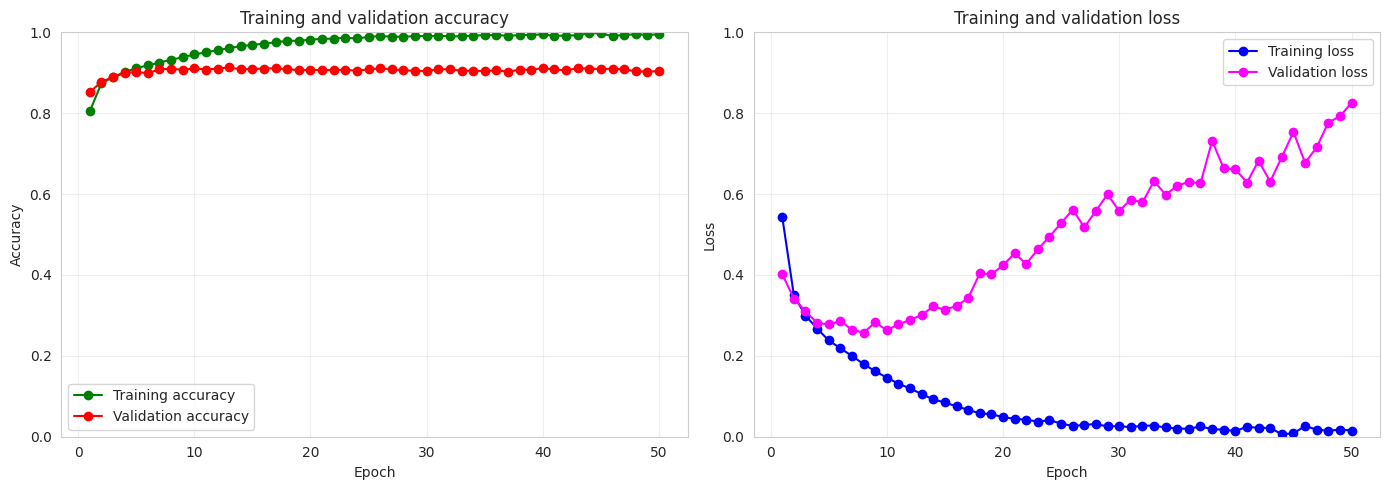

In [ ]:
plot_accuracy_and_loss(train_model,'outputs/train_model.png')

# ##  RE Train

In [96]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [97]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

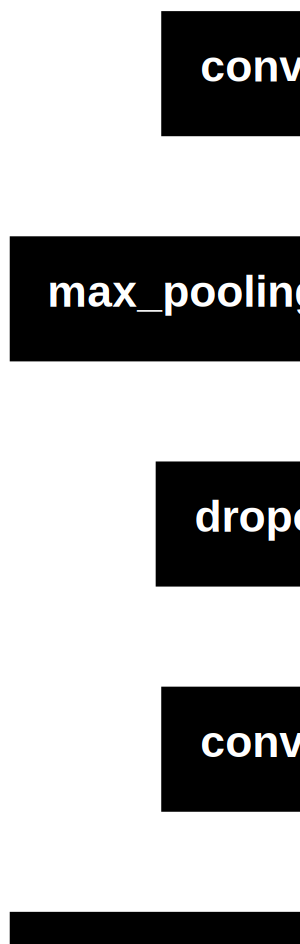

In [ ]:
plot_model(model, to_file='outputs/re_model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [99]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6140 - loss: 1.0656 - val_accuracy: 0.8323 - val_loss: 0.4555
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8147 - loss: 0.5050 - val_accuracy: 0.8652 - val_loss: 0.3679
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8491 - loss: 0.4134 - val_accuracy: 0.8830 - val_loss: 0.3231
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8663 - loss: 0.3671 - val_accuracy: 0.8971 - val_loss: 0.2936
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8753 - loss: 0.3353 - val_accuracy: 0.8938 - val_loss: 0.2962
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8766 - loss: 0.3269 - val_accuracy: 0.8996 - val_loss: 0.2777
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8869 - loss: 0.3057 - val_accuracy: 0.9013 - val_loss: 0.2654
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8910 - loss: 0.2985 - val_accuracy: 0.

In [100]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20182231068611145
Test accuracy: 0.926800012588501


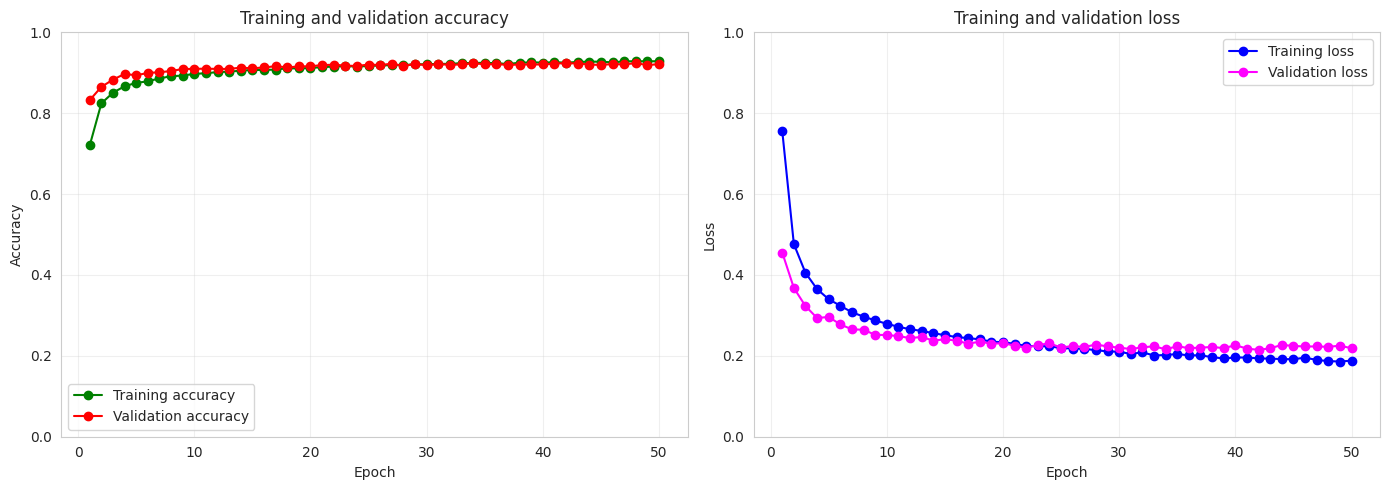

In [ ]:
plot_accuracy_and_loss(train_model,"outputs/re_train_model.png")

In [102]:
predicted_classes = np.argmax(model.predict(X_test), axis=-1)
y_true = test_data.iloc[:, 0]
p = predicted_classes[:10000]
y = y_true[:10000]
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Correct predicted classes: 9268
Incorrect predicted classes: 732


precision    recall  f1-score  

In [103]:
target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

                         precision    recall  f1-score   support

Class 0 (T-shirt/top) :       0.87      0.89      0.88      1000
    Class 1 (Trouser) :       0.99      0.99      0.99      1000
   Class 2 (Pullover) :       0.91      0.85      0.88      1000
      Class 3 (Dress) :       0.92      0.96      0.94      1000
       Class 4 (Coat) :       0.88      0.90      0.89      1000
     Class 5 (Sandal) :       0.99      0.97      0.98      1000
      Class 6 (Shirt) :       0.80      0.78      0.79      1000
    Class 7 (Sneaker) :       0.94      0.98      0.96      1000
        Class 8 (Bag) :       0.99      0.99      0.99      1000
 Class 9 (Ankle Boot) :       0.97      0.96      0.97      1000

               accuracy                           0.93     10000
              macro avg       0.93      0.93      0.93     10000
           weighted avg       0.93      0.93      0.93     10000



Sample Predictions

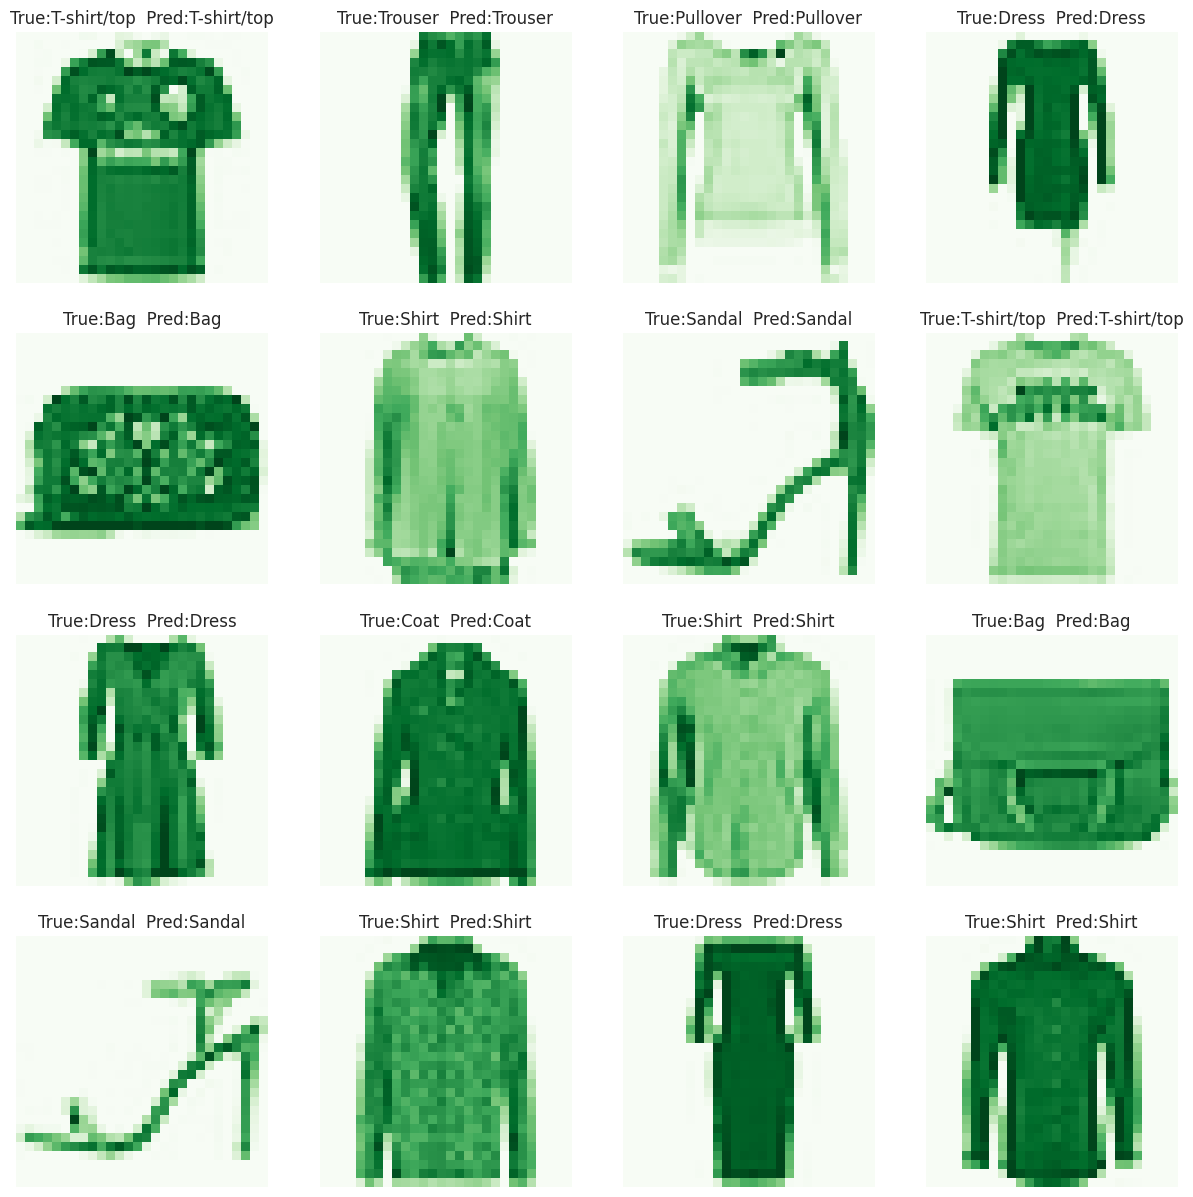

In [104]:
def plot_images(data_index,cmap="Blues"):
    figure, ax = plt.subplots(4,4, figsize=(15,15))

    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(X_test[indx].reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(labels[y_true[indx]],labels[predicted_classes[indx]]))
    plt.show()    
    
plot_images(correct, "Greens")

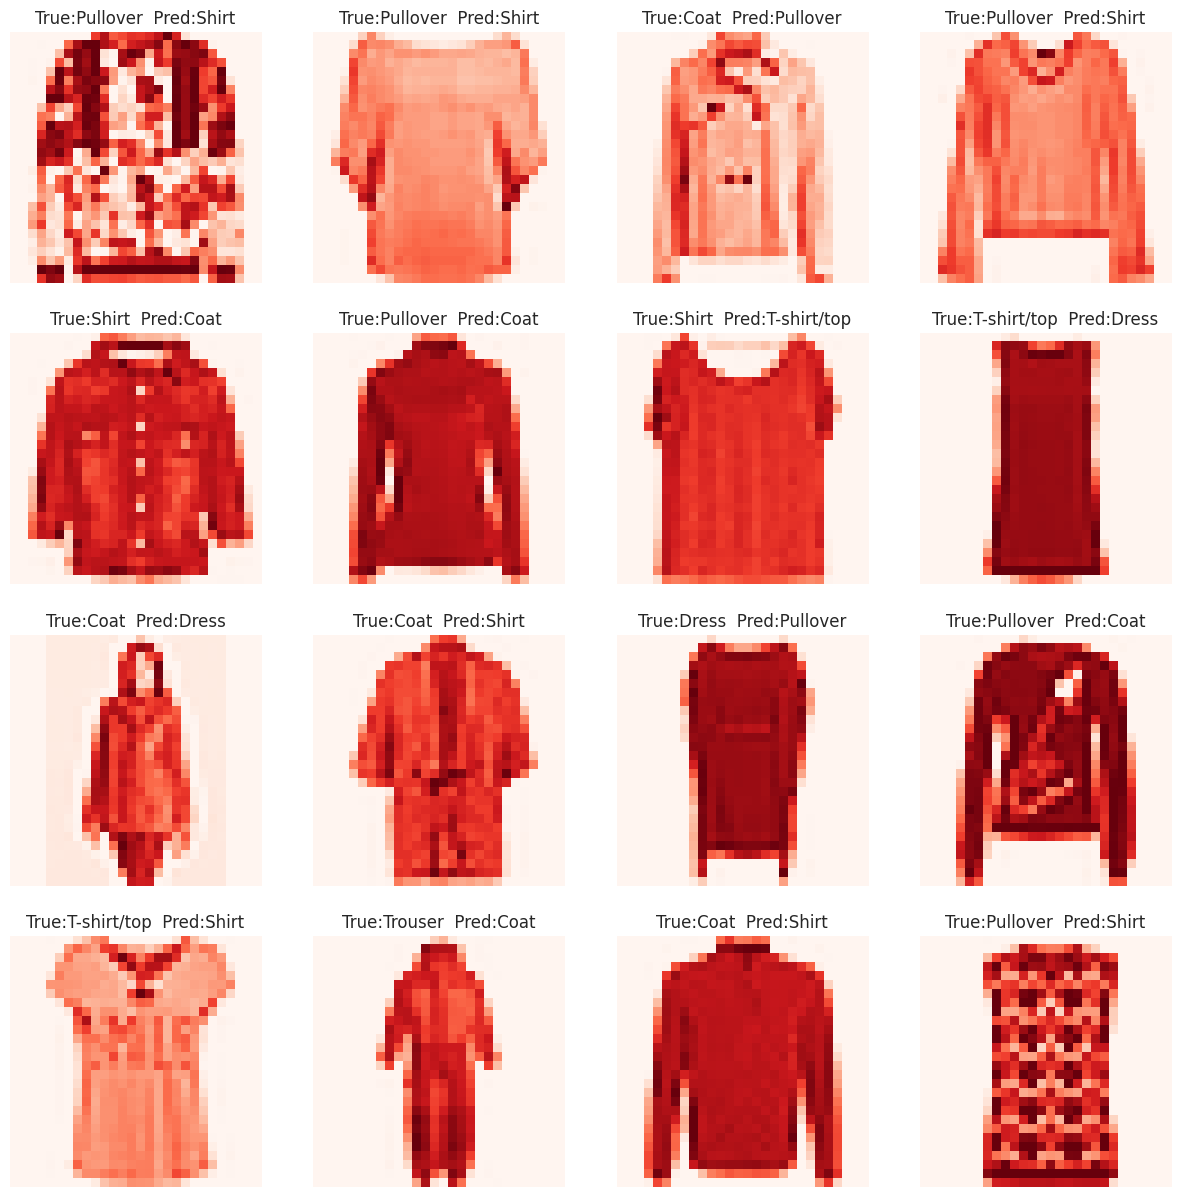

In [105]:
plot_images(incorrect, "Reds")

# SAVE MODEL

In [106]:
import json
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
model.save('fashion_model.h5')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


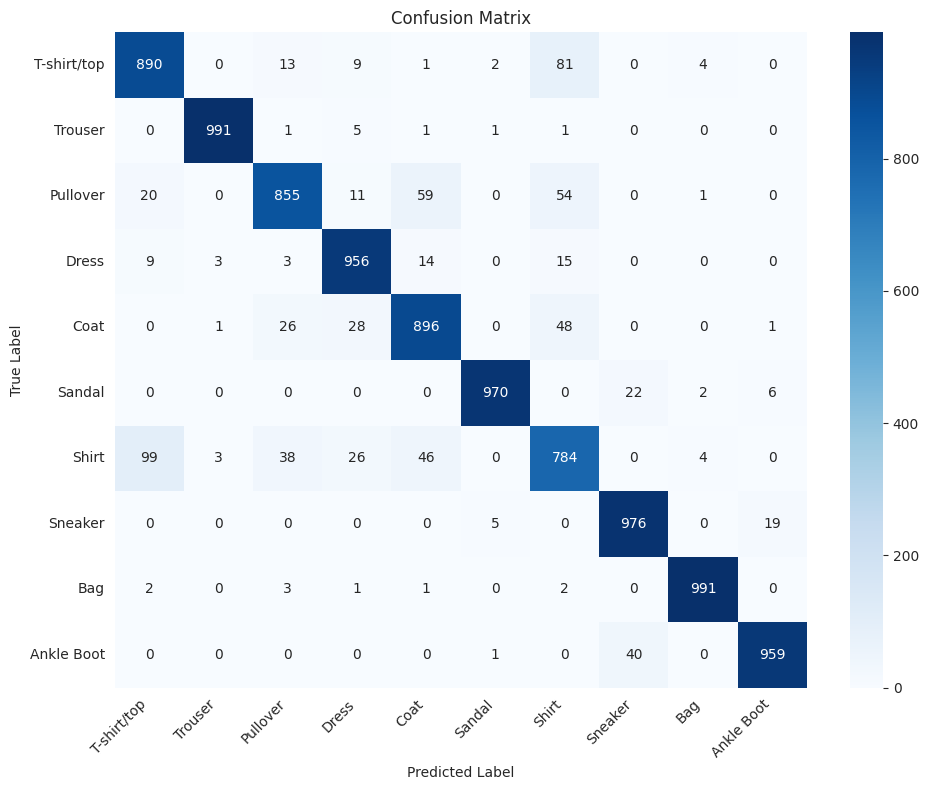

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[labels[i] for i in range(NUM_CLASSES)],
            yticklabels=[labels[i] for i in range(NUM_CLASSES)])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('outputs/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
np.save('outputs/confusion_matrix.npy', cm)

In [ ]:
from sklearn.metrics import classification_report
target_names = [labels[i] for i in range(NUM_CLASSES)]
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

with open('outputs/json/classification_report.json', 'w') as f:
    json.dump(report, f, indent=4)

In [ ]:
history_dict = {
    'accuracy': train_model.history['accuracy'],
    'val_accuracy': train_model.history['val_accuracy'],
    'loss': train_model.history['loss'],
    'val_loss': train_model.history['val_loss']
}
with open('outputs/json/training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=4)

In [ ]:
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), 16, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for i, idx in enumerate(sample_indices):
    ax = axes[i//4, i%4]
    ax.imshow(X_test[idx].reshape(IMG_ROWS, IMG_COLS), cmap='gray')
    ax.axis('off')
    
    true_label = labels[y_true[idx]]
    pred_label = labels[y_pred[idx]]
    color = 'green' if y_true[idx] == y_pred[idx] else 'red'
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", 
                 color=color, fontsize=10, weight='bold')

plt.suptitle('Sample Predictions', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('outputs/sample_predictions.png', dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
test_metrics = {
    'test_loss': float(score[0]),
    'test_accuracy': float(score[1])
}
with open('outputs/json/test_metrics.json', 'w') as file:
    json.dump(test_metrics, file, indent=4)
with open('outputs/json/labels.json', 'w') as file:
    json.dump(labels, file, indent=4)